In [151]:
import os

from matplotlib import pyplot as plt

import torch

from omegaconf import OmegaConf
from ase.visualize.plot import plot_atoms
from ase import Atoms
from schnetpack import properties
import schnetpack.transform as trn
from schnetpack.datasets import QM9

from morered.datasets import QM9Filtered
from morered.noise_schedules import PolynomialSchedule
from morered.processes import VPGaussianDDPM
from morered.utils import scatter_mean, check_validity, generate_bonds_data, batch_center_systems
from morered.sampling import DDPM

## !!! this needs to be updated as users may not have access to experiment folder. Upload config in addition to the model ? Seperate relaxation and sampling notebooks ?

# Helper functions

In [75]:
def plot_batch_molecules(batch):
    n_cols = len(batch[properties.idx_m].unique())
    n_rows = 1

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
    axs = axs.flatten()

    for i, ax in enumerate(axs):
        mask = batch[properties.idx_m] == i
        mol = Atoms(numbers=batch[properties.Z][mask], positions=batch[properties.R][mask])

        plot_atoms(mol, ax)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Paths

In [76]:
# experiment path
exp_path = "/home/twopaisquared/Desktop/projects/MoreRed/experiments/runs/9cef03dc-f0fd-11ee-bcbd-743af453b4c0"

# path to store the dataset as ASE '.db' files
split_file_path = os.path.join(exp_path, "split.npz")

# model path
model_path = os.path.join(exp_path, "best_model")

# config path
config_path = os.path.join(exp_path, "config.yaml")

In [77]:
# read configs using omegaconf
config = OmegaConf.load(config_path)

# Load model

In [78]:
denoiser = torch.load(model_path, map_location="cpu")

# Define sampler

In [79]:
# define the noise schedule
noise_schedule = PolynomialSchedule(T=1000, s=1e-5, dtype=torch.float64, variance_type="lower_bound")

# define the forward diffusion process
diff_proc = VPGaussianDDPM(noise_schedule, noise_key="eps", invariant=True, dtype=torch.float64)

In [80]:
ddpm_sampler = DDPM(
    diff_proc,
    denoiser,
    time_key="t",
    noise_key="eps_pred",
    cutoff=5.,
    recompute_neighbors=False,
    save_progress= True,
    progress_stride = 1,
    results_on_cpu = True,
)

# Define data loader

Define paths

In [81]:
tut_path = "./tut"

# path to store the dataset as ASE '.db' files
datapath = os.path.join(tut_path, "qm9.db")

# path to store a mapping between the DB indices and the number of atoms. Needed for filtered loading from the dataset
indices_path = os.path.join(tut_path, "n_atoms_indices.pkl") 

In [82]:
os.makedirs(tut_path, exist_ok=True)

Define data input transformations

In [83]:
transforms=[
    trn.CastTo64(),
    trn.SubtractCenterOfGeometry(),
]

Define dataset and dataloaders

In [84]:
qm9data = QM9Filtered(
    datapath=datapath,
    batch_size=8,
    n_atoms_allowed=config.data.n_atoms_allowed,
    shuffle_train=config.data.shuffle_train,
    n_overfit_molecules=config.data.n_overfit_molecules,
    permute_indices=config.data.permute_indices,
    repeat_indices=config.data.repeat_indices,
    remove_uncharacterized=True,
    num_train=128,
    num_val=128,
    num_test=128,
    transforms=transforms,
    property_units={QM9.U0: 'eV'},
    num_workers=2,
    split_file=split_file_path,
    indices_path=indices_path,
    pin_memory=False,
    load_properties=[QM9.U0]
)

In [85]:
# prepare and setup the dataset
qm9data.prepare_data()
qm9data.setup()

# Relaxing batches of diffused data

Load a batch

In [86]:
batch = next(iter(qm9data.train_dataloader()))

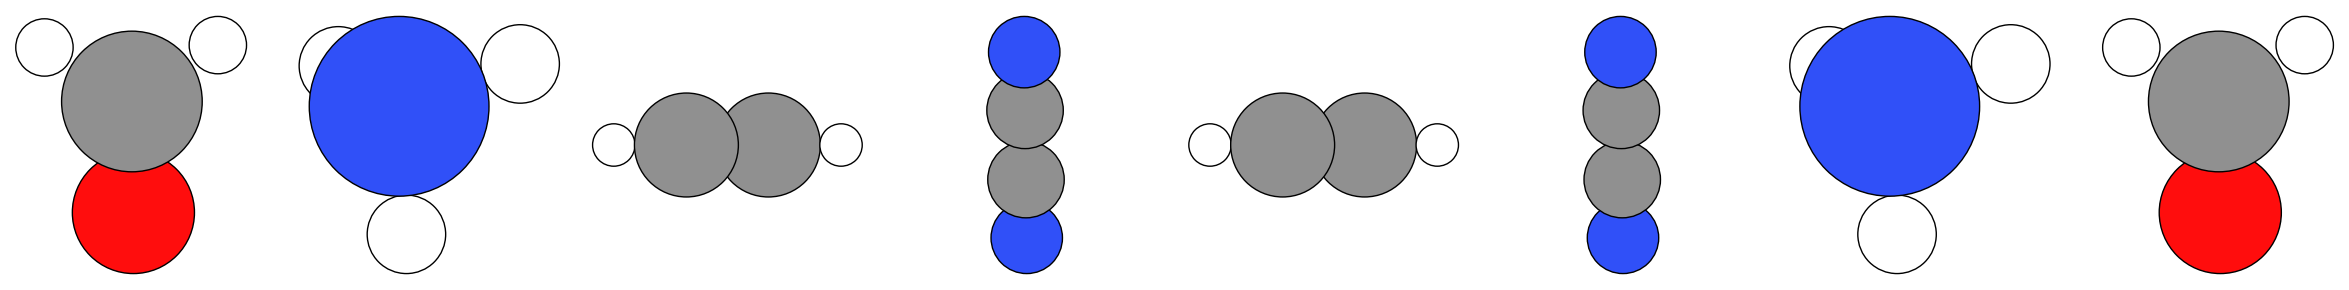

In [89]:
plot_batch_molecules(batch)

Diffuse the batch

In [90]:
# define the time step
t = 250

In [91]:
batch[properties.R], _ = diff_proc.diffuse(batch[properties.R], batch[properties.idx_m], t=torch.tensor(t))

In [92]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-15).all()

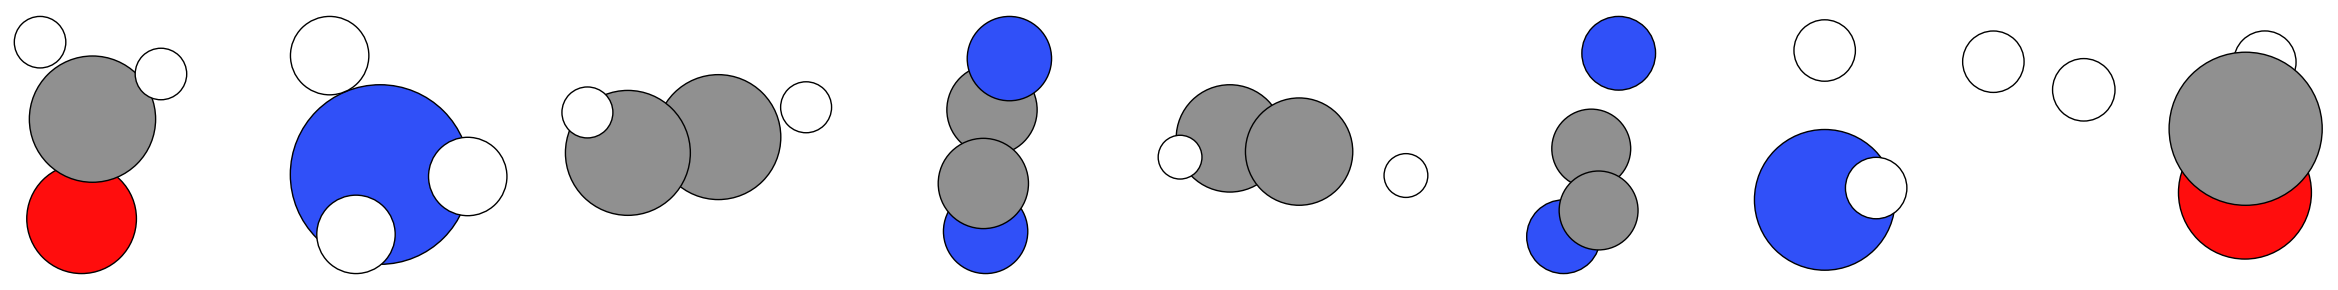

In [93]:
plot_batch_molecules(batch)

Denoise

In [94]:
relaxed, num_steps, hist = ddpm_sampler.denoise(batch, t=t)

100%|██████████| 250/250 [00:01<00:00, 150.48it/s]


In [95]:
batch.update(relaxed)

In [96]:
num_steps

tensor([250, 250, 250, 250, 250, 250, 250, 250])

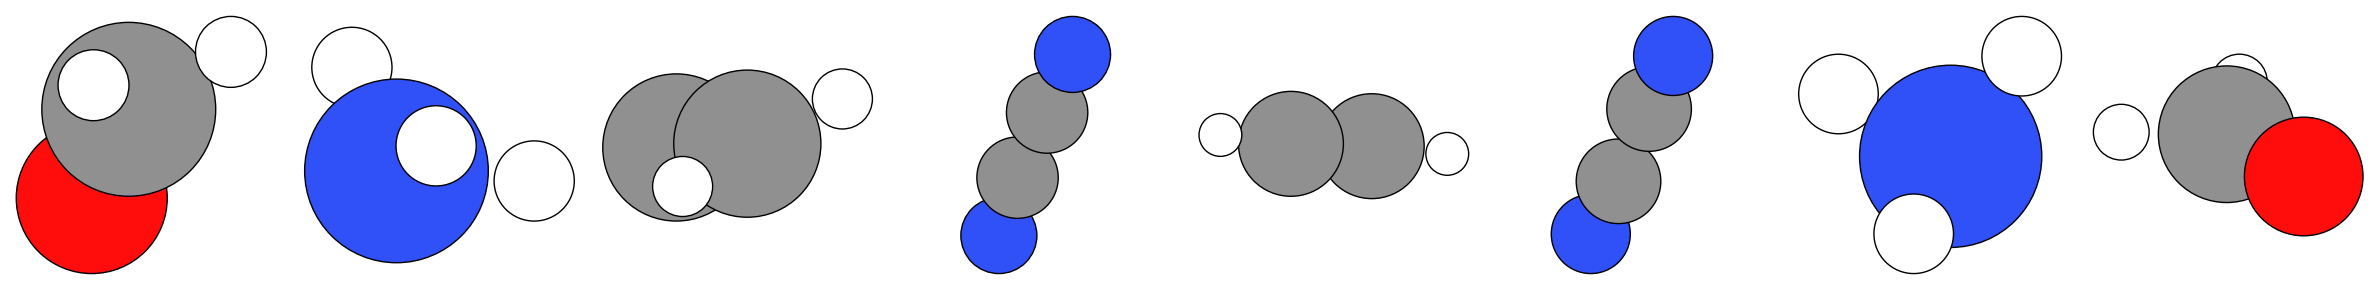

In [99]:
plot_batch_molecules(batch)

# Sample from scratch

Load a batch

In [100]:
batch = next(iter(qm9data.train_dataloader()))

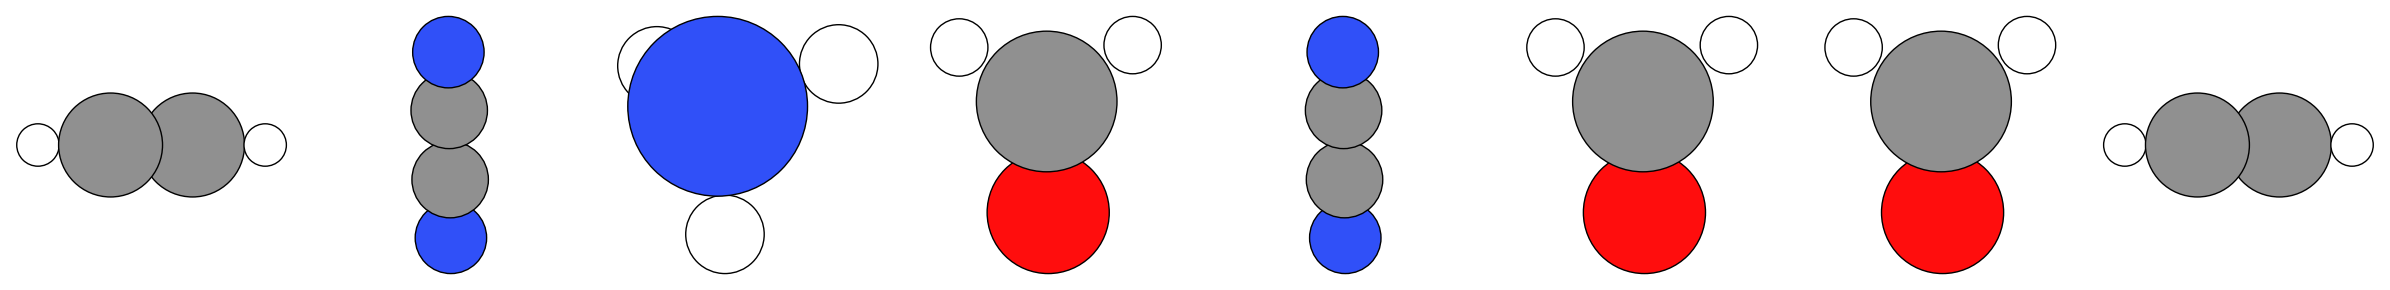

In [101]:
plot_batch_molecules(batch)

Sample random prior

In [102]:
x_T = ddpm_sampler.sample_prior(batch, t=None)

In [103]:
batch.update(x_T)

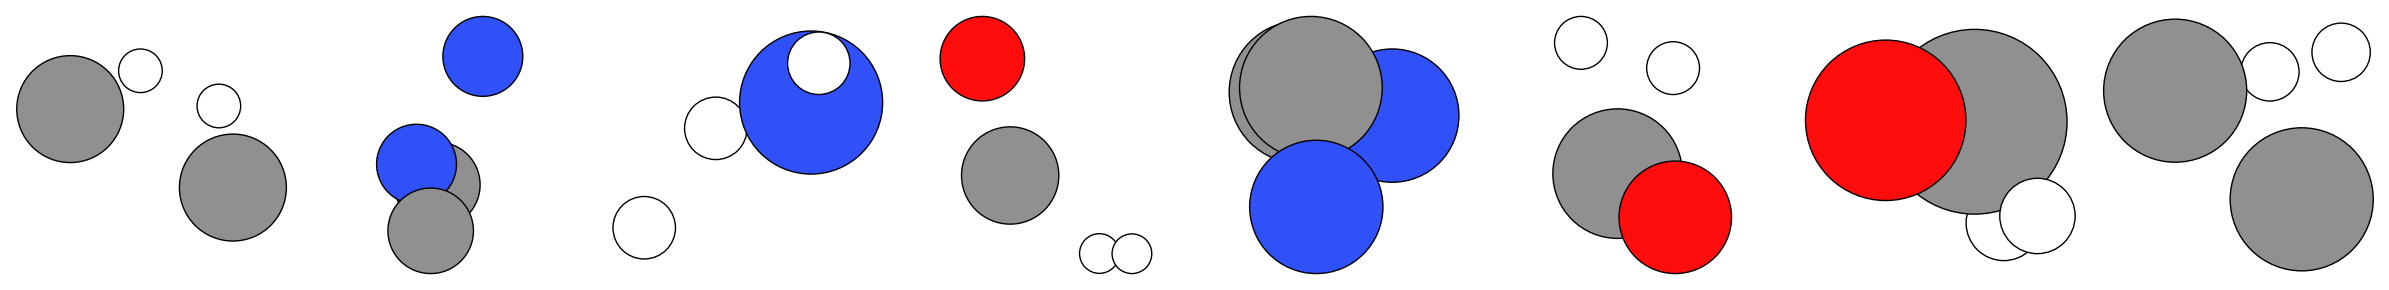

In [104]:
plot_batch_molecules(batch)

In [105]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-15).all()

In [106]:
samples, num_steps, hist = ddpm_sampler.denoise(batch, t=noise_schedule.T)

100%|██████████| 1000/1000 [00:07<00:00, 137.69it/s]


In [107]:
batch.update(samples)

In [108]:
num_steps

tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

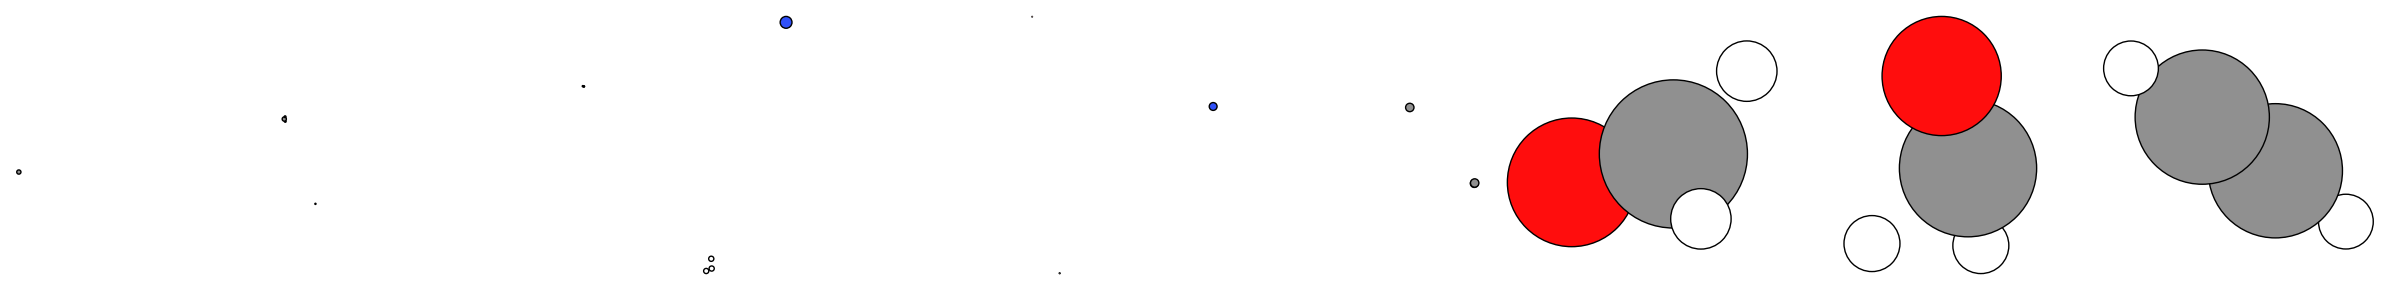

In [109]:
plot_batch_molecules(batch)

# Sample by manually using atomic numbers

Define the atomic numbers Z for p(X|Z)

In [117]:
Z = [
    torch.tensor([7, 6, 6, 7]),
    torch.tensor([6, 6, 1, 1]),
    torch.tensor([6, 8, 1, 1]),
]

Prepare the inputs

In [118]:
batch = ddpm_sampler.prepare_inputs(Z)

In [119]:
batch.keys()

dict_keys(['_atomic_numbers', '_n_atoms', '_positions', '_cell', '_pbc', '_idx', '_idx_m'])

In [120]:
# check if the centre of geometry for the molecules and sampled noise is zero
assert (scatter_mean(batch[properties.R], batch[properties.idx_m], batch[properties.n_atoms]) < 1e-15).all()

In [121]:
x_T = ddpm_sampler.sample_prior(batch, t=None)

In [122]:
batch.update(x_T)

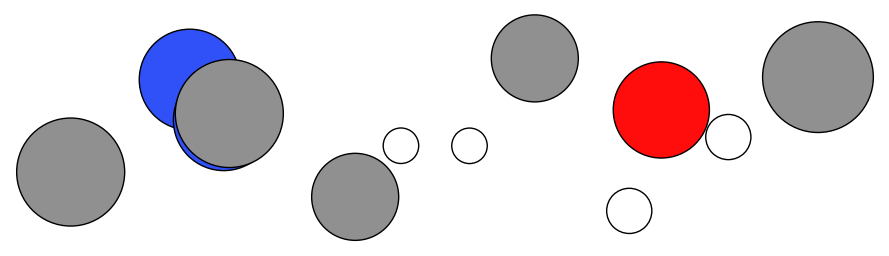

In [123]:
plot_batch_molecules(batch)

In [124]:
samples, num_steps, hist = ddpm_sampler.denoise(batch, t=noise_schedule.T)

100%|██████████| 1000/1000 [00:05<00:00, 180.18it/s]


In [125]:
batch.update(samples)

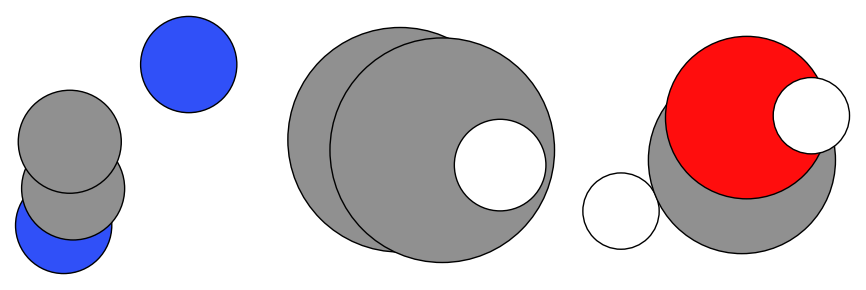

In [126]:
plot_batch_molecules(batch)

# Sampling History

In [144]:
time_steps = [
    scatter_mean(item["t"], batch[properties.idx_m], batch[properties.n_atoms]) 
                          for item in hist
]

In [145]:
time_steps[0].shape

torch.Size([3])

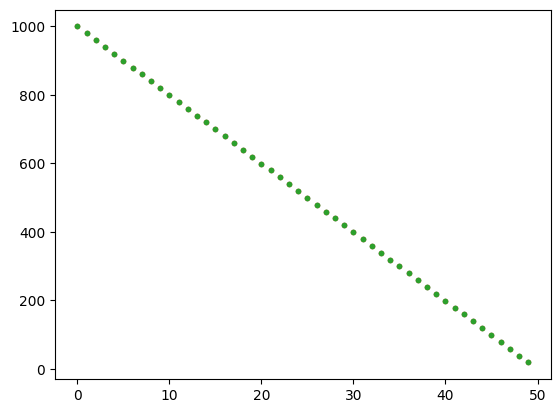

In [150]:
plt.plot(time_steps[::20], '.')
plt.show()

# Check validity

In [127]:
validity = check_validity(batch, *generate_bonds_data().values())

INFO:root:Bonds data already exists, skipping generation and reloading...
100%|██████████| 3/3 [00:00<00:00, 2336.66it/s]


In [128]:
validity['stable_molecules'], validity['stable_molecules_wo_h'], validity['connected'], validity['stable_atoms']

([False, True, False],
 [False, True, False],
 [False, True, False],
 [array([False,  True, False, False]),
  array([ True,  True,  True,  True]),
  array([ True, False,  True,  True])])